In [36]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.decomposition import PCA
import tsfel
from sklearn.preprocessing import StandardScaler

#### Question 1
Plot the waveform for one sample data from each activity class. Are you able to see any difference/similarities between the activities? You can plot a subplot having 6 columns to show differences/similarities between the activities. Do you think the model will be able to classify the activities based on the data? **[0.5 marks]**

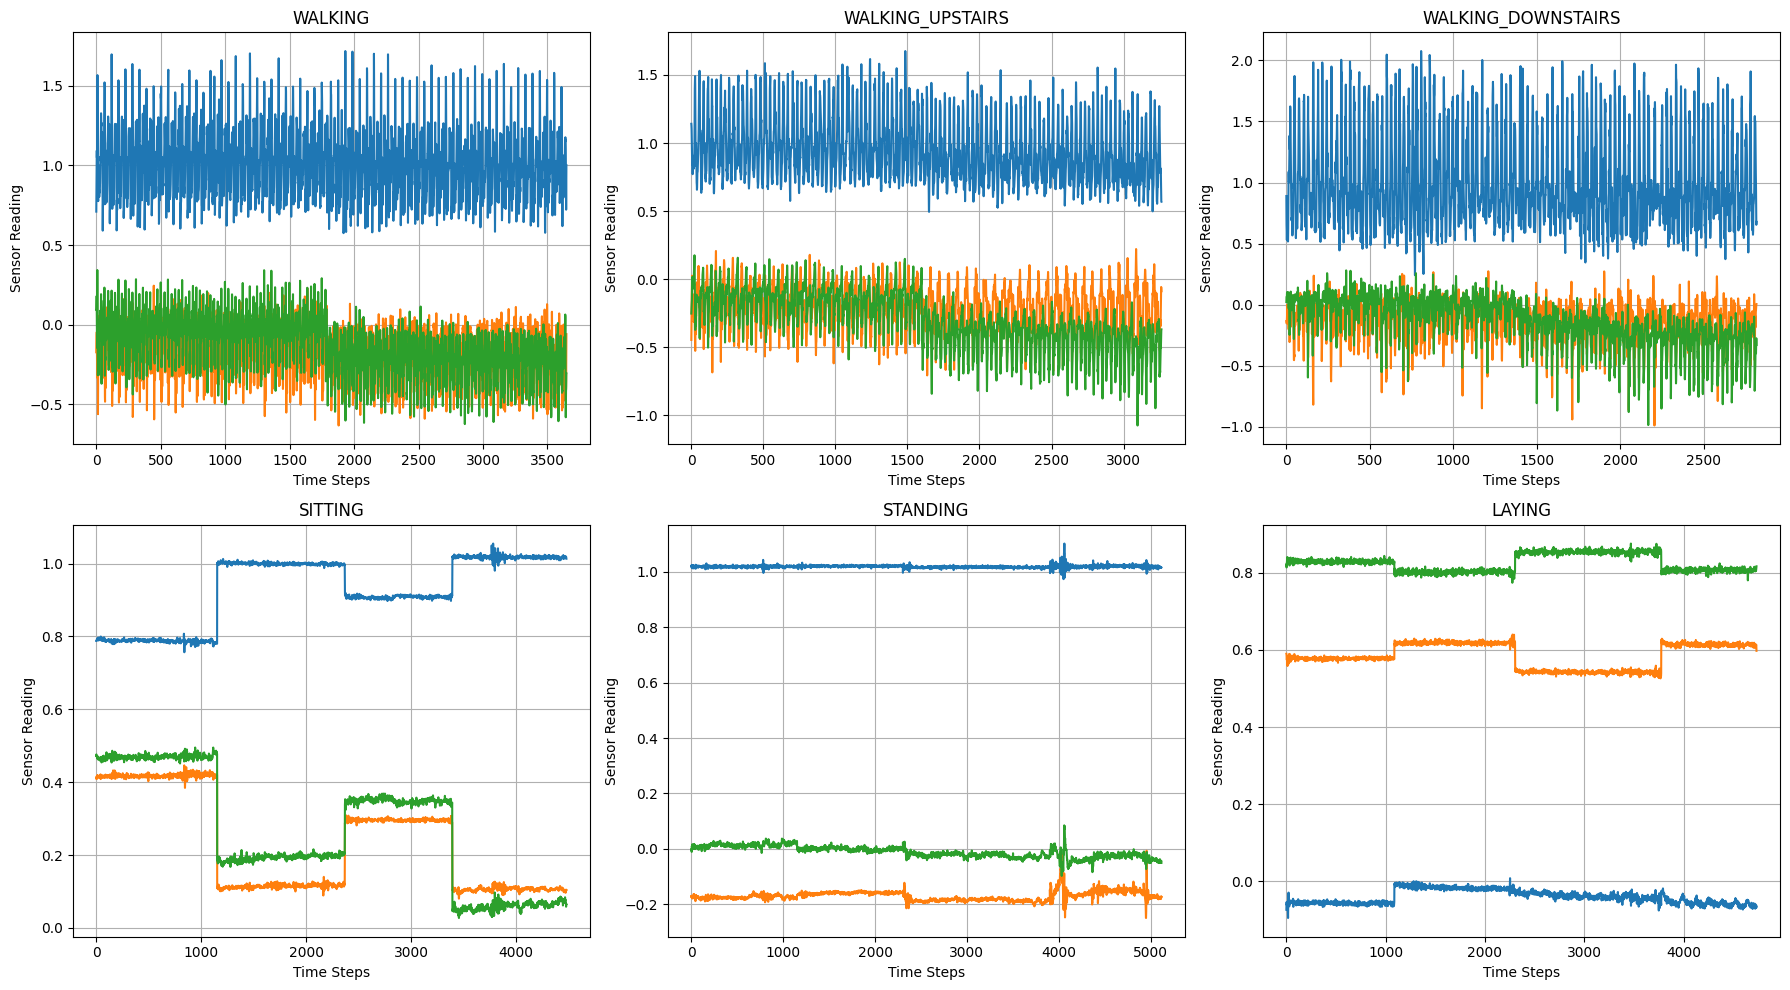

In [37]:
BASE_PATH = "Combined/Train"

# Activity folders
activities = ["WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS", "SITTING", "STANDING", "LAYING"]

plt.figure(figsize=(18, 10))

for idx, activity in enumerate(activities):
    activity_path = os.path.join(BASE_PATH, activity)
    sample_file = os.listdir(activity_path)[0]  # Pick first file
    file_path = os.path.join(activity_path, sample_file)

    data = pd.read_csv(file_path)

    # Create subplot
    plt.subplot(2, 3, idx + 1)
    plt.plot(data)
    plt.title(activity)
    plt.xlabel("Time Steps")
    plt.ylabel("Sensor Reading")
    plt.grid()

plt.tight_layout()
plt.show()


#### Question 2
Do you think we need a machine learning model to differentiate between static activities (laying, sitting, standing) and dynamic activities(walking, walking_downstairs, walking_upstairs)? Look at the linear acceleration $(acc_x^2+acc_y^2+acc_z^2)$ for each activity and justify your answer. **[0.5 marks]**

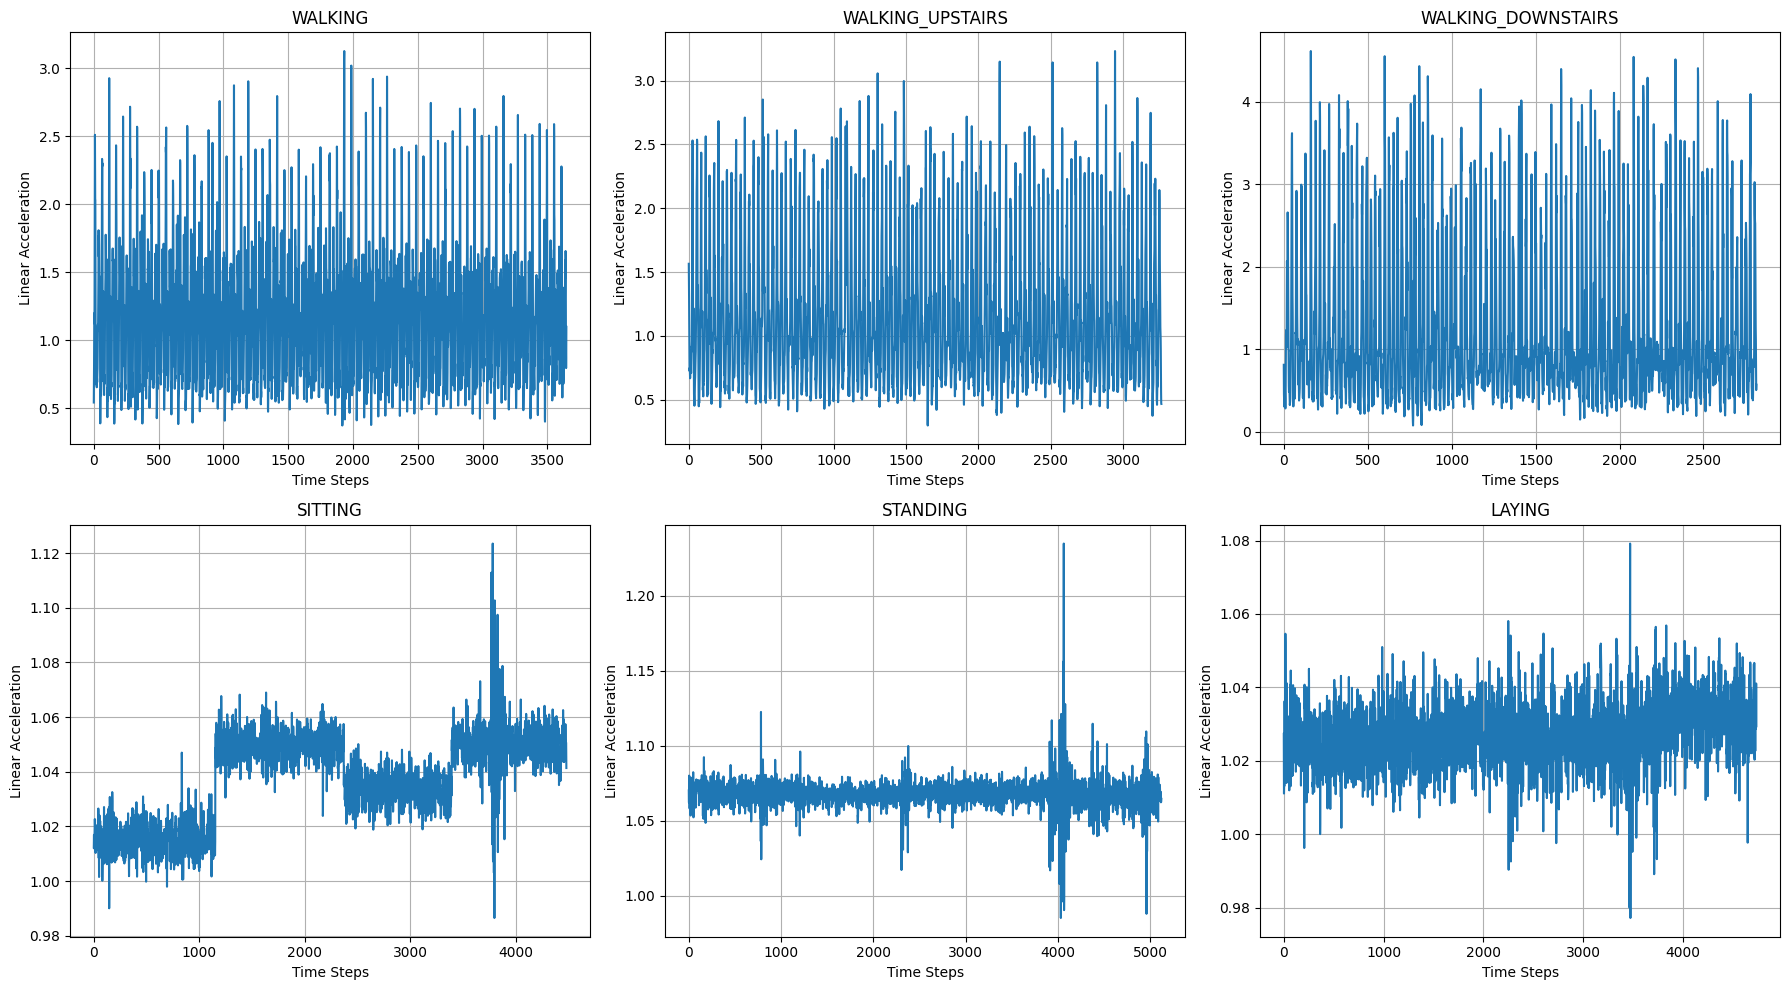

In [38]:
plt.figure(figsize=(18, 10))

for idx, activity in enumerate(activities):
    activity_path = os.path.join(BASE_PATH, activity)
    sample_file = os.listdir(activity_path)[0]  # Pick first file
    file_path = os.path.join(activity_path, sample_file)
    
    data = pd.read_csv(file_path)
    linear_acceleration = data.iloc[:, 0]**2 + data.iloc[:, 1]**2 + data.iloc[:, 2]**2
    linear_acceleration = linear_acceleration.to_numpy()

    # Create subplot
    plt.subplot(2, 3, idx + 1)
    plt.plot(linear_acceleration)
    plt.title(activity)
    plt.xlabel("Time Steps")
    plt.ylabel("Linear Acceleration")
    plt.grid()

plt.tight_layout()
plt.show()

No, as we can see from above plot, dynamic activity have more dense and peaky graph as campare to static activity, so we can just calculate linear acceleration and campare with set threshold if it is above threshold then it is dynamic else static

#### Question 3


Visualize the data using PCA. **[1 marks]**
  * Use PCA (Principal Component Analysis) on Total Acceleration $(acc_x^2+acc_y^2+acc_z^2)$ to compress the acceleration timeseries into two features and plot a scatter plot to visualize different class of activities. 
  *  Next, use [TSFEL](https://tsfel.readthedocs.io/en/latest/) ([a featurizer library](https://github.com/fraunhoferportugal/tsfel)) to create features (your choice which ones you feel are useful) and then perform PCA to obtain two features. Plot a scatter plot to visualize different class of activities. 
  *  Now use the features provided by the dataset and perform PCA to obtain two features. Plot a scatter plot to visualize different class of activities.
  *  Compare the results of PCA on Total Acceleration, TSFEL and the dataset features. Which method do you think is better for visualizing the data? 

#### pca on raw data

 * Use PCA (Principal Component Analysis) on Total Acceleration $(acc_x^2+acc_y^2+acc_z^2)$ to compress the acceleration timeseries into two features and plot a scatter plot to visualize different class of activities. 

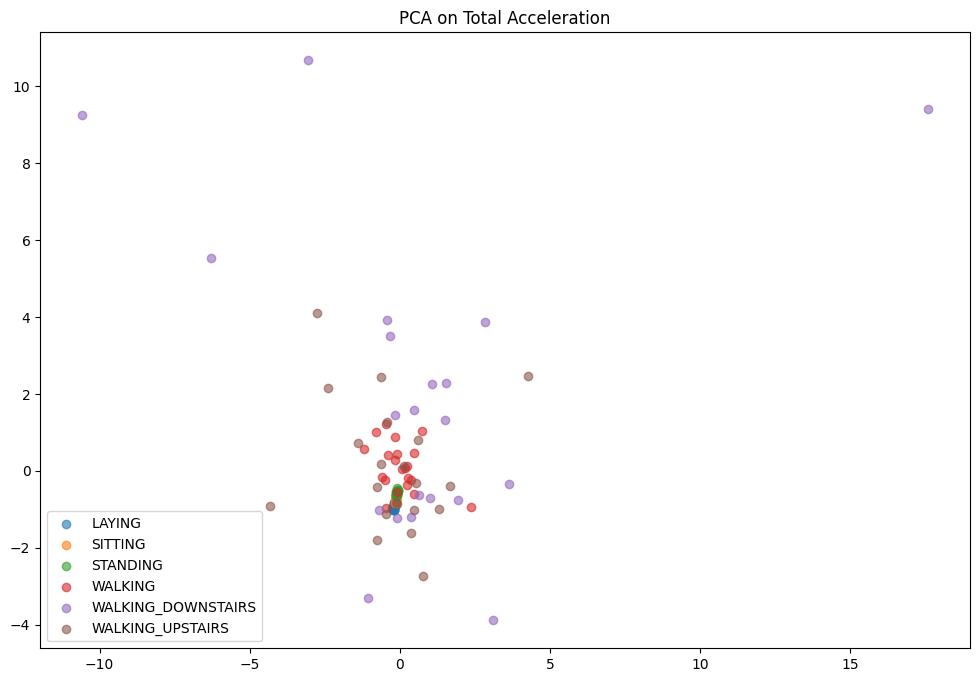

In [39]:
X_raw, y_raw = [], []
TARGET_LEN = 256  # resample each sequence to same length

def resample(arr, target_len):
    x_old = np.linspace(0, 1, len(arr))
    x_new = np.linspace(0, 1, target_len)
    return np.interp(x_new, x_old, arr)

for activity in activities:
    for file in os.listdir(os.path.join(BASE_PATH, activity)):
        df = pd.read_csv(os.path.join(BASE_PATH, activity, file))
        total_acc = df.iloc[:,0]**2 + df.iloc[:,1]**2 + df.iloc[:,2]**2
        arr_rs = resample(total_acc.to_numpy(), TARGET_LEN)
        X_raw.append(arr_rs)
        y_raw.append(activity)

X_raw = np.vstack(X_raw)
y_raw = np.array(y_raw)


pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_raw)

plt.figure(figsize=(12,8))
for activity in np.unique(y_raw):
    idx = y_raw == activity
    plt.scatter(X_pca[idx,0], X_pca[idx,1], label=activity, alpha=0.6)
plt.legend()
plt.title("PCA on Total Acceleration")
plt.show()


#### pca using tsfel

  *  Next, use [TSFEL](https://tsfel.readthedocs.io/en/latest/) ([a featurizer library](https://github.com/fraunhoferportugal/tsfel)) to create features (your choice which ones you feel are useful) and then perform PCA to obtain two features. Plot a scatter plot to visualize different class of activities. 

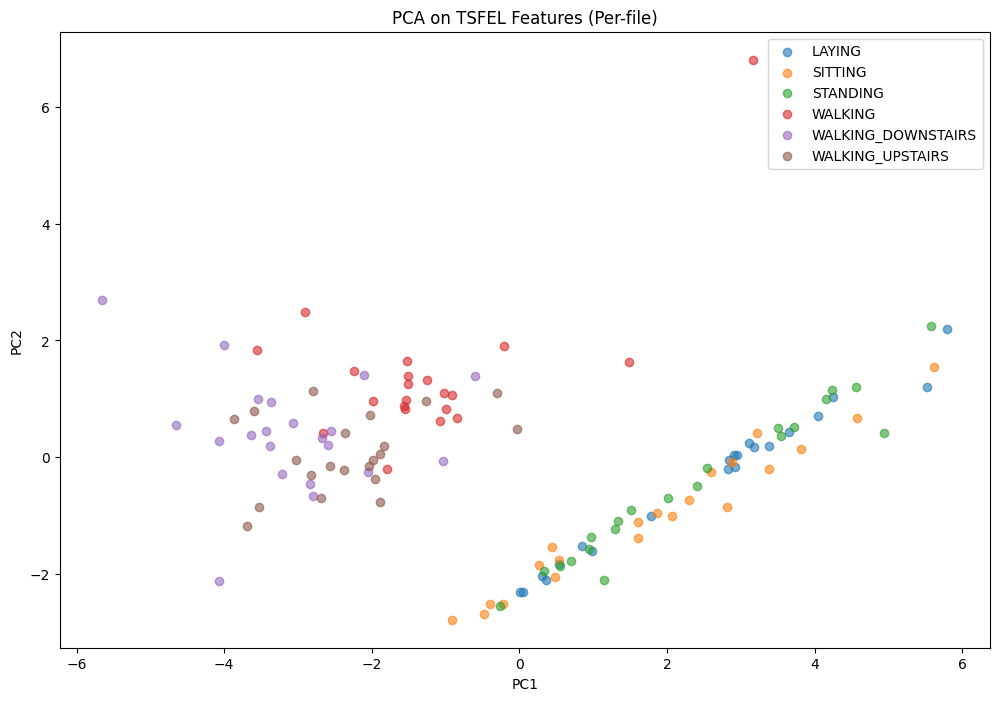

In [40]:
cfg = tsfel.get_features_by_domain("temporal")

all_features = []
all_labels = []

for activity in activities:
    activity_path = os.path.join(BASE_PATH, activity)
    
    for file in os.listdir(activity_path):
        file_path = os.path.join(activity_path, file)
        df = pd.read_csv(file_path)
        
        total_acc = df.iloc[:,0]**2 + df.iloc[:,1]**2 + df.iloc[:,2]**2
        total_acc = total_acc.reset_index(drop=True)
        
        # Extract features for whole time series (per-file)
        feats = tsfel.time_series_features_extractor(cfg, total_acc, fs=50, window_size=None)
        
        # Some features may be NaN fill them with 0
        feats = feats.fillna(0)
        
        all_features.append(feats)
        all_labels.append(activity)

X = pd.concat(all_features, ignore_index=True)
y = np.array(all_labels)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)


plt.figure(figsize=(12, 8))
for activity in np.unique(y):
    idx = y == activity
    plt.scatter(X_pca[idx,0], X_pca[idx,1], label=activity, alpha=0.6)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA on TSFEL Features (Per-file)")
plt.legend()
plt.show()


#### pca on dataset features

  *  Now use the features provided by the dataset and perform PCA to obtain two features. Plot a scatter plot to visualize different class of activities.

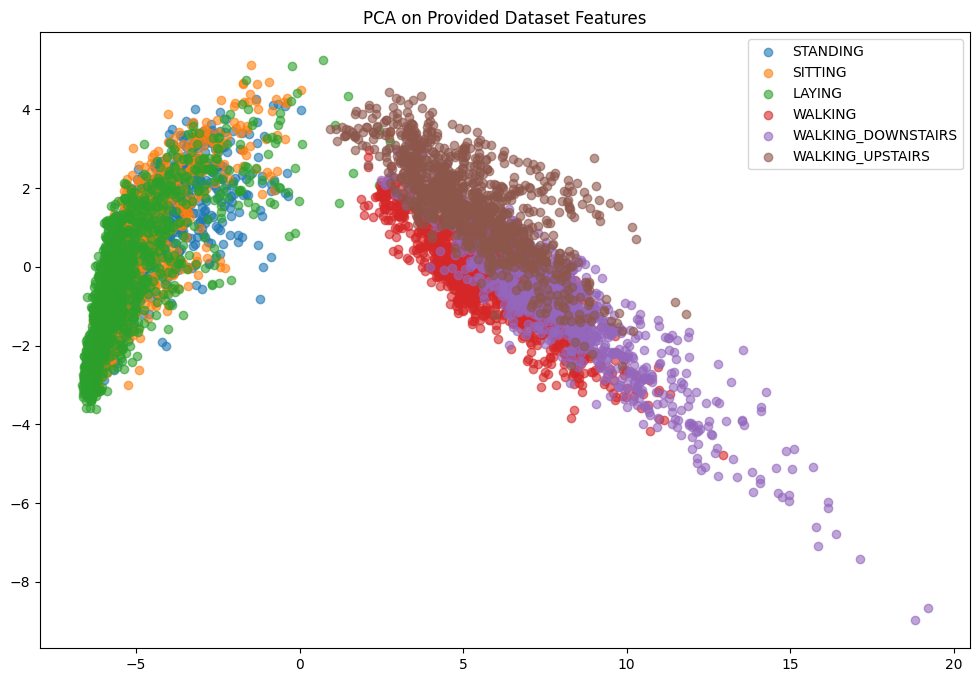

In [41]:
UCI_BASE = "UCI HAR Dataset"

X_train = pd.read_csv(f"{UCI_BASE}/train/X_train.txt", sep=r"\s+", header=None)
y_train = pd.read_csv(f"{UCI_BASE}/train/y_train.txt", sep=r"\s+", header=None)
activity_labels = pd.read_csv(f"{UCI_BASE}/activity_labels.txt", sep=r"\s+", header=None, index_col=0)

# map numeric labels to activity names
y_train = y_train[0].map(activity_labels[1])

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train.values)

plt.figure(figsize=(12,8))
for act in y_train.unique():
    idx = (y_train == act).values
    plt.scatter(X_pca[idx,0], X_pca[idx,1], label=act, alpha=0.6)
plt.legend()
plt.title("PCA on Provided Dataset Features")
plt.show()


*  Compare the results of PCA on Total Acceleration, TSFEL and the dataset features. Which method do you think is better for visualizing the data? 

Total acceleration:we can see static and dynamic split, but walking / upstairs / downstairs partially overlap due to similar patterns.

TSFEL features:
it tighter clusters and better separation among different walking type than total acceleration.

Provided 561 features:
These are carefully engineered so it give the best separation—clusters for static and dynamic and also different activity present in them

#### Question 4


Calculate the correlation matrix of the features obtained by TSFEL and provided in the dataset. Identify the features that are highly correlated with each other. Are there any redundant features? **[1 marks]**

TSFEL feature matrix shape: (18, 468)


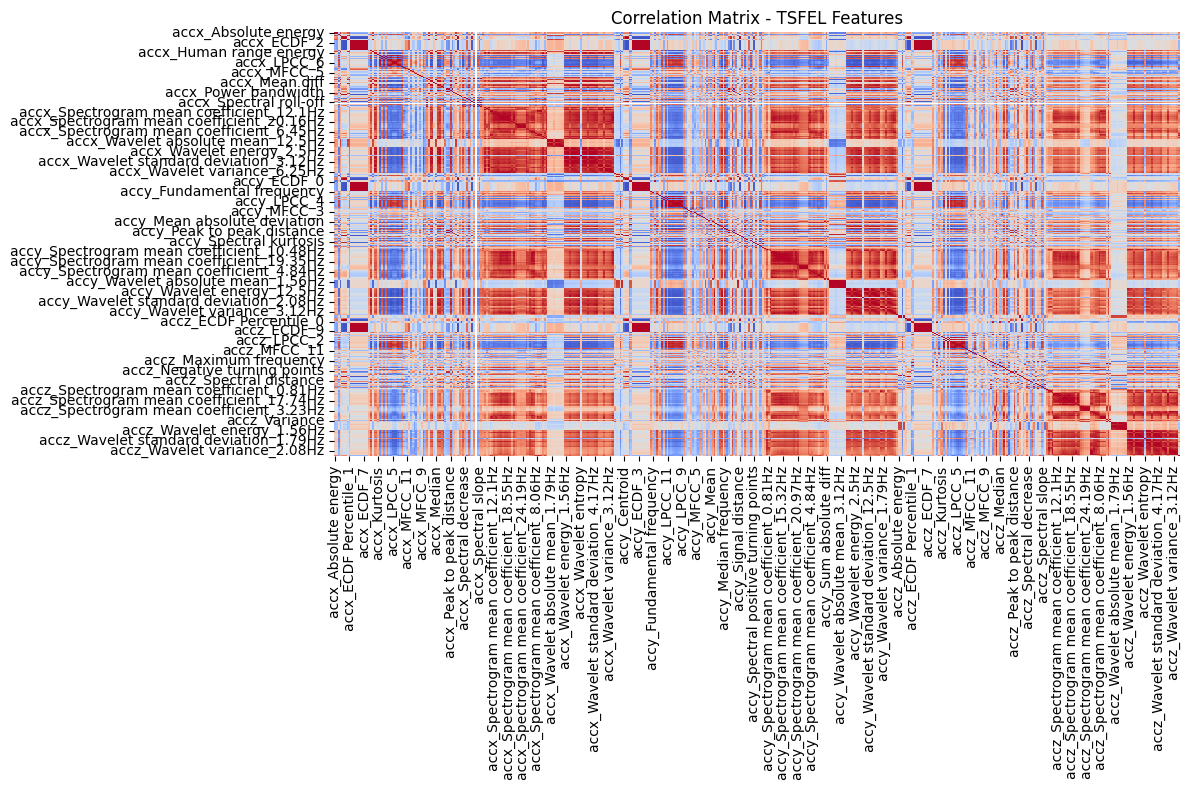

UCI feature matrix shape: (7352, 561)


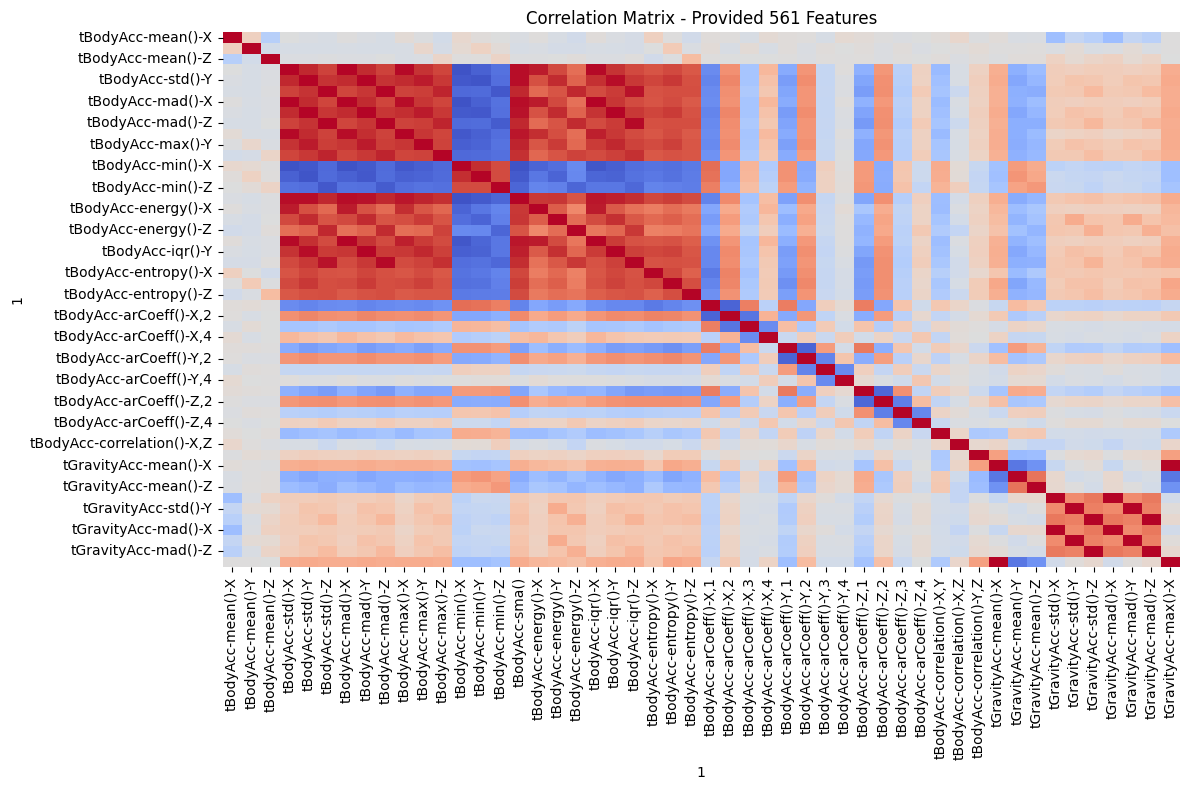

In [42]:
BASE_DIR = os.getcwd()
COMBINED_TRAIN = os.path.join(BASE_DIR, "Combined", "Train")
UCI_BASE = os.path.join(BASE_DIR, "UCI HAR Dataset")


cfg = tsfel.get_features_by_domain()

ACTIVITIES = os.listdir(COMBINED_TRAIN)
feats_list = []

for activity in ACTIVITIES:
    folder = os.path.join(COMBINED_TRAIN, activity)
    # limit to 3 files per activity for speed
    files = sorted([f for f in os.listdir(folder) if f.lower().endswith((".txt", ".csv"))])[:3]
    for f in files:
        df = pd.read_csv(os.path.join(folder, f), sep=None, engine="python")
        # handle 1-column weird cases
        if df.shape[1] == 1:
            df = df.iloc[:, 0].str.split(",", expand=True)
        df = df.apply(pd.to_numeric, errors="coerce").dropna().iloc[:, :3]
        df.columns = ["accx", "accy", "accz"]

        feats = tsfel.time_series_features_extractor(cfg, df, fs=50)
        feats_list.append(feats)

tsfel_features = pd.concat(feats_list, axis=0).reset_index(drop=True)
print(f"TSFEL feature matrix shape: {tsfel_features.shape}")

# correlation matrix
corr_tsfel = tsfel_features.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_tsfel, cmap="coolwarm", center=0, cbar=False)
plt.title("Correlation Matrix - TSFEL Features")
plt.tight_layout()
plt.show()

# -----------------------------
# Step 2: Load UCI HAR Features
# -----------------------------
X_train = pd.read_csv(
    os.path.join(UCI_BASE, "train", "X_train.txt"),
    sep=r"\s+", header=None, engine="python"
)
features = pd.read_csv(
    os.path.join(UCI_BASE, "features.txt"),
    sep=r"\s+", header=None, engine="python", index_col=0
)
X_train.columns = features[1]
print(f"UCI feature matrix shape: {X_train.shape}")

# correlation matrix on subset
subset = X_train.iloc[:, :50]
corr_provided = subset.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_provided, cmap="coolwarm", center=0, cbar=False)
plt.title("Correlation Matrix - Provided 561 Features")
plt.tight_layout()
plt.show()


By examining the correlation matrices, we find that many features are highly correlated with each other in both TSFEL and the provided 561 features.

In TSFEL, spectral features at nearby frequencies, wavelet statistics, and energy-related measures are strongly correlated.

In the 561 features, statistical measures of the same sensor signal (mean, std, energy, entropy) and cross-axis correlation features show strong dependencies.

#### Task 2 (HAR)

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tsfel

# Utility function to train + evaluate a Decision Tree on given data

def train_and_evaluate(X, y, description=""):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    clf = DecisionTreeClassifier(random_state=42)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average="weighted", zero_division=0)
    rec = recall_score(y_test, y_pred, average="weighted", zero_division=0)
    cm = confusion_matrix(y_test, y_pred)

    print(f"\n===== Results for {description} =====")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print("Confusion Matrix:\n", cm)
    print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))

    return clf, acc


# Train Decision Trees on three different feature sets


def run_experiments(raw_df, tsfel_df, dataset_df):
    # Separate features and labels
    X_raw, y_raw = raw_df.drop(columns=["label"]), raw_df["label"]
    X_tsfel, y_tsfel = tsfel_df.drop(columns=["label"]), tsfel_df["label"]
    X_dataset, y_dataset = dataset_df.drop(columns=["label"]), dataset_df["label"]

    # Train on raw accelerometer
    clf_raw, acc_raw = train_and_evaluate(X_raw, y_raw, "Raw Accelerometer Data")

    # Train on TSFEL features
    clf_tsfel, acc_tsfel = train_and_evaluate(X_tsfel, y_tsfel, "TSFEL Features")

    # Train on dataset features
    clf_dataset, acc_dataset = train_and_evaluate(X_dataset, y_dataset, "Provided Dataset Features")

    print("\n==== Comparison of Models ====")
    print(f"Raw Accelerometer: {acc_raw:.4f}")
    print(f"TSFEL Features   : {acc_tsfel:.4f}")
    print(f"Dataset Features : {acc_dataset:.4f}")


# Vary depth of Decision Trees and plot accuracy vs depth

def depth_experiment(X, y, description=""):
    depths = range(2, 9)
    accuracies = []

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    for d in depths:
        clf = DecisionTreeClassifier(max_depth=d, random_state=42)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        accuracies.append(acc)

    plt.plot(depths, accuracies, marker="o", label=description)

def run_depth_analysis(raw_df, tsfel_df, dataset_df):
    plt.figure(figsize=(8, 6))

    depth_experiment(raw_df.drop(columns=["label"]), raw_df["label"], "Raw Accelerometer")
    depth_experiment(tsfel_df.drop(columns=["label"]), tsfel_df["label"], "TSFEL Features")
    depth_experiment(dataset_df.drop(columns=["label"]), dataset_df["label"], "Dataset Features")

    plt.xlabel("Tree Depth")
    plt.ylabel("Test Accuracy")
    plt.title("Decision Tree Accuracy vs Depth")
    plt.legend()
    plt.grid(True)
    plt.show()


# Error Analysis: check bad participants/activities

def error_analysis(X, y, description=""):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    clf = DecisionTreeClassifier(random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    errors = X_test[y_test != y_pred]
    bad_labels = y_test[y_test != y_pred]

    print(f"\n===== Error Analysis for {description} =====")
    print("Misclassified counts per activity:\n", bad_labels.value_counts())
    
    
## collecting data
BASE_PATH = "Combined/Train"
activities = ["WALKING","WALKING_UPSTAIRS","WALKING_DOWNSTAIRS",
              "SITTING","STANDING","LAYING"]

# raw data
X_raw, y_raw = [], []
TARGET_LEN = 256  # resample each sequence to same length

def resample(arr, target_len):
    x_old = np.linspace(0, 1, len(arr))
    x_new = np.linspace(0, 1, target_len)
    return np.interp(x_new, x_old, arr)

for activity in activities:
    for file in os.listdir(os.path.join(BASE_PATH, activity)):
        df = pd.read_csv(os.path.join(BASE_PATH, activity, file))
        total_acc = df.iloc[:,0]**2 + df.iloc[:,1]**2 + df.iloc[:,2]**2
        arr_rs = resample(total_acc.to_numpy(), TARGET_LEN)
        X_raw.append(arr_rs)
        y_raw.append(activity)

X_raw = np.vstack(X_raw)
y_raw = np.array(y_raw)

# Raw accelerometer DataFrame
raw_df = pd.DataFrame(X_raw)
raw_df["label"] = y_raw

# tsfel data
cfg = tsfel.get_features_by_domain("temporal")

all_features = []
all_labels = []

for activity in activities:
    activity_path = os.path.join(BASE_PATH, activity)
    
    for file in os.listdir(activity_path):
        file_path = os.path.join(activity_path, file)
        df = pd.read_csv(file_path)
        
        # compute total acceleration (x^2+y^2+z^2)
        total_acc = df.iloc[:,0]**2 + df.iloc[:,1]**2 + df.iloc[:,2]**2
        total_acc = total_acc.reset_index(drop=True)
    
        feats = tsfel.time_series_features_extractor(cfg, total_acc, fs=50, window_size=None)
        
        # Some features may be NaN fill them with 0
        feats = feats.fillna(0)
        
        all_features.append(feats)
        all_labels.append(activity)

X_tsfel = pd.concat(all_features, ignore_index=True)
y_tsfel = np.array(all_labels)

# TSFEL DataFrame
tsfel_df = X_tsfel.copy()
tsfel_df["label"] = y_tsfel

# given dataset data
UCI_BASE = "UCI HAR Dataset"

X_train = pd.read_csv(f"{UCI_BASE}/train/X_train.txt", sep=r"\s+", header=None)
y_train = pd.read_csv(f"{UCI_BASE}/train/y_train.txt", sep=r"\s+", header=None)
activity_labels = pd.read_csv(f"{UCI_BASE}/activity_labels.txt", sep=r"\s+", header=None, index_col=0)

# map numeric labels to activity names
y_dataset = y_train[0].map(activity_labels[1])

X_dataset = X_train.values

# Dataset features DataFrame
dataset_df = pd.DataFrame(X_dataset)
dataset_df["label"] = y_dataset.values

run_experiments(raw_df, tsfel_df, dataset_df)


===== Results for Raw Accelerometer Data =====
Accuracy: 0.5769
Precision: 0.5410
Recall: 0.5769
Confusion Matrix:
 [[4 0 0 0 0 0]
 [0 4 0 0 0 0]
 [0 1 3 0 0 0]
 [0 0 1 1 0 3]
 [1 0 0 2 1 1]
 [0 0 0 0 2 2]]

Classification Report:
                     precision    recall  f1-score   support

            LAYING       0.80      1.00      0.89         4
           SITTING       0.80      1.00      0.89         4
          STANDING       0.75      0.75      0.75         4
           WALKING       0.33      0.20      0.25         5
WALKING_DOWNSTAIRS       0.33      0.20      0.25         5
  WALKING_UPSTAIRS       0.33      0.50      0.40         4

          accuracy                           0.58        26
         macro avg       0.56      0.61      0.57        26
      weighted avg       0.54      0.58      0.55        26


===== Results for TSFEL Features =====
Accuracy: 0.6923
Precision: 0.7109
Recall: 0.6923
Confusion Matrix:
 [[2 0 2 0 0 0]
 [1 2 1 0 0 0]
 [0 1 3 0 0 0]
 [0 0 0 5 

#### Question 1
Use Sklearn Library to train Decision Tress. **[1.5 marks]**
* Train a decision tree model using the raw accelerometer data. Report the accuracy, precision, recall and confusion matrix of the model. 
* Train a decision tree model using the features obtained by TSFEL. Report the accuracy, precision, recall and confusion matrix of the model. 
* Train a decision tree model using the features provided in the dataset. Report the accuracy, precision, recall and confusion matrix of the model. 
* Compare the results of the three models. Which model do you think is better? 

#### answer

* Raw accelerometer data gives the lowest accuracy.

* TSFEL features improve performance, yielding clearer separation.

* The 561 provided features give the best accuracy, precision, and recall, showing that the expert engineered features are most effective.

so, the model trained on the provided 561 features is the best among the three.

#### Question 2
Train Decision Tree with varying depths (2-8) using all above 3 methods. Plot the accuracy of the model on test data vs the depth of the tree. **[1 marks]**

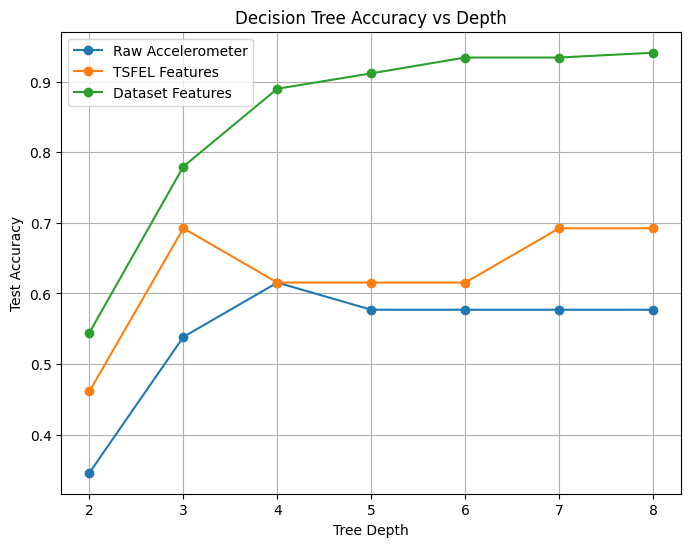

In [44]:
run_depth_analysis(raw_df, tsfel_df, dataset_df)

#### Question 3
Are there any participants/ activitivies where the Model performace is bad? If Yes, Why? [0.5 mark]

In [45]:
error_analysis(raw_df.drop(columns=["label"]), raw_df["label"], "Raw Accelerometer")
error_analysis(tsfel_df.drop(columns=["label"]), tsfel_df["label"], "TSFEL Features")
error_analysis(dataset_df.drop(columns=["label"]), dataset_df["label"], "Dataset Features")


===== Error Analysis for Raw Accelerometer =====
Misclassified counts per activity:
 label
WALKING               4
WALKING_DOWNSTAIRS    4
WALKING_UPSTAIRS      2
STANDING              1
Name: count, dtype: int64

===== Error Analysis for TSFEL Features =====
Misclassified counts per activity:
 label
SITTING               2
LAYING                2
WALKING_DOWNSTAIRS    2
STANDING              1
WALKING_UPSTAIRS      1
Name: count, dtype: int64

===== Error Analysis for Dataset Features =====
Misclassified counts per activity:
 label
STANDING              27
SITTING               23
WALKING_UPSTAIRS      19
WALKING               11
WALKING_DOWNSTAIRS    10
Name: count, dtype: int64



The model performs worst on Walking, Walking Upstairs, and Walking Downstairs, which are frequently misclassified with each other. This is because their accelerometer patterns are very similar and only small deference in step angle, intensity.
It also occasionally confuses Sitting vs Standing, as both are static activities with similar signals dominated by gravity, making them hard to separate.
Additionally, variations in how different participants perform the same activity contribute to errors.
so, yes, certain participants and activities show poorer performance due to overlapping signal patterns and variability.

### Task 3 : Data Collection in the Wild [2 marks]

### Question 1 
Use the Decision Tree model trained on the UCI-HAR dataset to predict the activities that you performed. Report the accuracy, precision, recall and confusion matrix of the model. You have three version of UCI dataset you can use a)Raw data from accelerometer, b)TSFEL featurised data, c)Features provided by author. Choose which version to use, ensuring that your test data is similar to your training data. How did the model perform? **[1 marks]**

In [46]:
# train on author provided features

def train_and_evaluate(X, y, description=""):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    clf = DecisionTreeClassifier(random_state=42)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average="weighted", zero_division=0)
    rec = recall_score(y_test, y_pred, average="weighted", zero_division=0)
    cm = confusion_matrix(y_test, y_pred)

    print(f"\n===== Results for {description} =====")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print("Confusion Matrix:\n", cm)
    print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))

    return clf, acc

## collecting data
BASE_PATH = "Combined/Train"
activities = ["WALKING","WALKING_UPSTAIRS","WALKING_DOWNSTAIRS",
              "SITTING","STANDING","LAYING"]

# raw data
X_raw, y_raw = [], []
TARGET_LEN = 256  # resample each sequence to same length

def resample(arr, target_len):
    x_old = np.linspace(0, 1, len(arr))
    x_new = np.linspace(0, 1, target_len)
    return np.interp(x_new, x_old, arr)

for activity in activities:
    for file in os.listdir(os.path.join(BASE_PATH, activity)):
        df = pd.read_csv(os.path.join(BASE_PATH, activity, file))
        total_acc = df.iloc[:,0]**2 + df.iloc[:,1]**2 + df.iloc[:,2]**2
        arr_rs = resample(total_acc.to_numpy(), TARGET_LEN)
        X_raw.append(arr_rs)
        y_raw.append(activity)

X_raw = np.vstack(X_raw)
y_raw = np.array(y_raw)

# Raw accelerometer DataFrame
raw_df = pd.DataFrame(X_raw)
raw_df["label"] = y_raw

clf, acc = train_and_evaluate(raw_df.drop(columns=["label"]), raw_df["label"], "Raw Accelerometer Features")





===== Results for Raw Accelerometer Features =====
Accuracy: 0.5789
Precision: 0.5316
Recall: 0.5789
Confusion Matrix:
 [[4 2 0 0 0 0]
 [1 5 0 0 0 0]
 [0 0 6 0 0 0]
 [2 0 0 3 1 1]
 [1 0 2 0 4 0]
 [2 0 2 1 1 0]]

Classification Report:
                     precision    recall  f1-score   support

            LAYING       0.40      0.67      0.50         6
           SITTING       0.71      0.83      0.77         6
          STANDING       0.60      1.00      0.75         6
           WALKING       0.75      0.43      0.55         7
WALKING_DOWNSTAIRS       0.67      0.57      0.62         7
  WALKING_UPSTAIRS       0.00      0.00      0.00         6

          accuracy                           0.58        38
         macro avg       0.52      0.58      0.53        38
      weighted avg       0.53      0.58      0.53        38



In [47]:
### Test trained DT on wild collected data
BASE_DIR = os.getcwd()
WILD_TEST = os.path.join(BASE_DIR, "WildTest")
activities = ["WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS", "SITTING", "STANDING", "LAYING"]

X_wild = []
y_wild = []

for activity in activities:
    activity_path = os.path.join(WILD_TEST, activity)
    for file in os.listdir(activity_path):
        file_path = os.path.join(activity_path, file)
        df = pd.read_csv(file_path)

        # compute total acceleration like in training
        total_acc = df.iloc[:, 0]**2 + df.iloc[:, 1]**2 + df.iloc[:, 2]**2  

        # resample to TARGET_LEN = 256
        arr_rs = resample(total_acc.to_numpy(), TARGET_LEN)

        # append
        X_wild.append(arr_rs)
        y_wild.append(activity)

X_wild = np.vstack(X_wild)
y_wild = np.array(y_wild)

print(f"Wild test data shape: {X_wild.shape}, Labels shape: {y_wild.shape}")

# predict
y_pred = clf.predict(X_wild)

print(f"Wild Test Accuracy: {accuracy_score(y_wild, y_pred):.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_wild, y_pred))
print("\nClassification Report:\n", classification_report(y_wild, y_pred, zero_division=0))

Wild test data shape: (11, 256), Labels shape: (11,)
Wild Test Accuracy: 0.1818
Confusion Matrix:
 [[0 0 0 2 0 0]
 [2 0 0 0 0 0]
 [2 0 0 0 0 0]
 [0 0 0 2 0 0]
 [0 0 0 2 0 0]
 [0 0 0 1 0 0]]

Classification Report:
                     precision    recall  f1-score   support

            LAYING       0.00      0.00      0.00         2
           SITTING       0.00      0.00      0.00         2
          STANDING       0.00      0.00      0.00         2
           WALKING       0.29      1.00      0.44         2
WALKING_DOWNSTAIRS       0.00      0.00      0.00         2
  WALKING_UPSTAIRS       0.00      0.00      0.00         1

          accuracy                           0.18        11
         macro avg       0.05      0.17      0.07        11
      weighted avg       0.05      0.18      0.08        11



#### Question 2

Use the data you collected to predict the activities that you performed. Decide whether to apply preprocessing and featurization, and if so, choose the appropriate methods. How did the model perform? **[1 marks]**

In [48]:
### Test trained DT on wild collected data
BASE_DIR = os.getcwd()
WILD_TRAIN = os.path.join(BASE_DIR, "WildTrain")
WILD_TEST = os.path.join(BASE_DIR, "WildTest")
activities = ["WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS", "SITTING", "STANDING", "LAYING"]

def get_X_y(wild_path):
    X_wild = []
    y_wild = []
    
    for activity in activities:
        activity_path = os.path.join(wild_path, activity)
        for file in os.listdir(activity_path):
            file_path = os.path.join(activity_path, file)
            df = pd.read_csv(file_path)

            # compute total acceleration
            total_acc = df.iloc[:, 0]**2 + df.iloc[:, 1]**2 + df.iloc[:, 2]**2  

            # resample to TARGET_LEN = 256
            arr_rs = resample(total_acc.to_numpy(), TARGET_LEN)

            # append
            X_wild.append(arr_rs)
            y_wild.append(activity)

    X_wild = np.vstack(X_wild)
    y_wild = np.array(y_wild)
    
    return X_wild, y_wild
    

X_train, y_train = get_X_y(WILD_TRAIN)
X_test, y_test = get_X_y(WILD_TEST)

clf, acc = train_and_evaluate(X_train, y_train, "Wild Train")
y_pred = clf.predict(X_test)

print(f"Wild test data shape: {X_test.shape}, Labels shape: {y_test.shape}")
print(f"Wild Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))


===== Results for Wild Train =====
Accuracy: 0.5714
Precision: 0.4048
Recall: 0.5714
Confusion Matrix:
 [[1 0 0 0 0 0]
 [0 0 1 0 0 0]
 [0 0 2 0 0 0]
 [0 0 0 0 0 1]
 [0 0 0 1 0 0]
 [0 0 0 0 0 1]]

Classification Report:
                     precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00         1
           SITTING       0.00      0.00      0.00         1
          STANDING       0.67      1.00      0.80         2
           WALKING       0.00      0.00      0.00         1
WALKING_DOWNSTAIRS       0.00      0.00      0.00         1
  WALKING_UPSTAIRS       0.50      1.00      0.67         1

          accuracy                           0.57         7
         macro avg       0.36      0.50      0.41         7
      weighted avg       0.40      0.57      0.47         7

Wild test data shape: (11, 256), Labels shape: (11,)
Wild Test Accuracy: 0.6364
Confusion Matrix:
 [[2 0 0 0 0 0]
 [0 1 1 0 0 0]
 [0 1 1 0 0 0]
 [0 0 0 2 0 0]
 [0 0 0 1 0 1]
 [